Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.925568
[100]	valid_0's auc: 0.92656
[150]	valid_0's auc: 0.926802
[200]	valid_0's auc: 0.926931
[250]	valid_0's auc: 0.926987
Early stopping, best iteration is:
[230]	valid_0's auc: 0.927076

Validation AUC: 0.9271


<Figure size 1000x600 with 0 Axes>

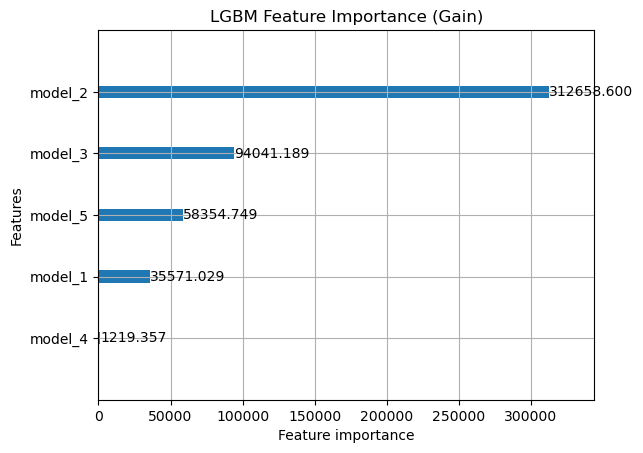

c:\Users\Admin\anaconda3\Lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


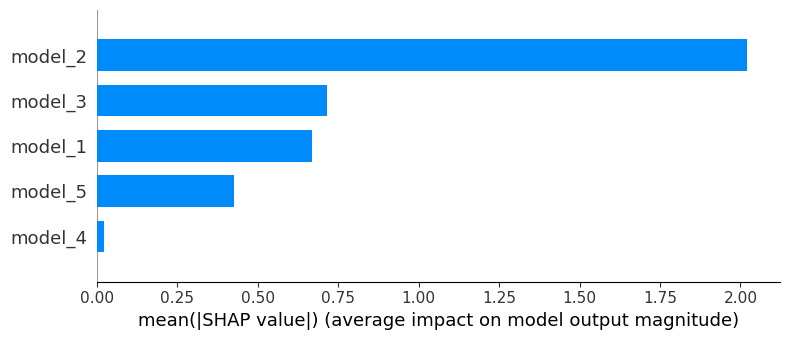

In [12]:
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

# Загрузка данных
tr = pd.read_parquet('data/train.parquet')
tst = pd.read_parquet('data/test.parquet')

def prepare_data(df, train_columns=None):
    """Подготовка данных: удаление datetime столбцов и обработка категориальных"""
    # Удаляем столбцы с datetime
    datetime_cols = df.select_dtypes(include=['datetime64', 'timedelta64']).columns
    df = df.drop(columns=datetime_cols)
    
    # Конвертируем категориальные в числовые
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in cat_cols:
        df[col] = pd.factorize(df[col])[0]
    
    # Если переданы train_columns, оставляем только нужные колонки
    if train_columns is not None:
        # Находим пересечение колонок
        common_cols = list(set(df.columns) & set(train_columns))
        df = df[common_cols]
        
        # Добавляем недостающие колонки с нулями
        missing_cols = list(set(train_columns) - set(common_cols))
        for col in missing_cols:
            df[col] = 0
    
    return df

def train_simple_lgbm(train_data, y_train, test_data):
    # Подготовка данных
    X = prepare_data(train_data.copy())
    X_train, X_val, y_train_split, y_val = train_test_split(
        X, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    
    # Параметры LGBM
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'random_state': 42
    }
    
    # Создадим датасеты для LGBM
    train_data = lgb.Dataset(X_train, label=y_train_split)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    
    # Обучим модель
    model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=True),
            lgb.log_evaluation(50)
        ]
    )
    
    # Оценка качества
    val_pred = model.predict(X_val)
    val_auc = roc_auc_score(y_val, val_pred)
    print(f"\nValidation AUC: {val_auc:.4f}")
    
    # Важность фичей
    plt.figure(figsize=(10, 6))
    lgb.plot_importance(model, importance_type='gain')
    plt.title("LGBM Feature Importance (Gain)")
    plt.show()
    
    # SHAP-анализ
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_val)
    
    shap.summary_plot(shap_values, X_val, 
                     feature_names=X_val.columns.tolist(),
                     plot_type="bar")
    
    # Подготовка тестовых данных с теми же колонками, что и в обучении
    X_test = prepare_data(test_data.copy(), train_columns=X.columns.tolist())
    
    # Предсказание для теста
    test_meta_preds = model.predict(X_test)
    
    return test_meta_preds, model

# Запуск модели
preds, trained_model = train_simple_lgbm(
    tr.drop(columns=['target']), 
    tr.target, 
    tst
)

In [14]:
tst['preds'] = preds
tst

,order_id,order_create_time,session_end_time,model_1,model_2,model_3,model_4,model_5,preds
0,1350922,1976-02-05 15:08:37,1976-02-05 15:04:28.867,-1.710108,0.203183,0.040015,1,0.442343,0.238040
1,1354989,1976-02-07 15:26:00,1976-02-07 15:27:26.593,0.086020,0.220081,0.021101,1,0.191027,0.266833
2,1352637,1976-02-06 11:43:58,1976-02-05 18:34:59.477,-0.438741,0.644805,0.066312,0,0.400509,0.632344
3,1350050,1976-02-05 11:26:19,1976-02-05 11:09:28.247,-1.395752,0.203183,0.083039,1,0.414590,0.238040
4,1341733,1976-02-01 19:36:32,1976-02-01 09:53:54.103,-0.441443,0.644805,0.052902,0,0.411544,0.632344
...,...,...,...,...,...,...,...,...,...
17191,1358397,1976-02-09 16:13:20,1976-02-02 09:02:14.140,-0.429658,0.644805,0.908250,0,0.196781,0.092395
17192,1357968,1976-02-09 14:30:59,1976-02-09 14:26:24.480,-1.710108,0.203183,0.040665,0,0.411543,0.591445
17193,1358835,1976-02-09 18:39:45,1976-02-09 18:30:36.407,0.086020,0.644805,0.039744,1,0.426308,0.273150
17194,1365692,1976-02-12 17:50:18,1976-02-12 16:13:15.153,-1.710108,0.203183,0.041701,0,0.433750,0.591445


In [ ]:
import numpy as np
import lightgbm as lgb
import optuna
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import pandas as pd

tr = pd.read_parquet('data/train.parquet')
tst = pd.read_parquet('data/test.parquet')

def train_meta_lgbm_with_optuna(train_predictions, y_train, test_predictions, n_trials=5):
    # Преобразуем DataFrame в numpy array для правильной работы с индексами
    X = train_predictions.values
    y = y_train.values
    
    # Оптимизация гиперпараметров LGBM
    def objective(trial):
        params = {
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
            'random_state': 42,
            'verbosity': -1
        }
        
        # Кросс-валидация
        scores = []
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        for train_idx, val_idx in skf.split(X, y):
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]
            
            model = lgb.LGBMClassifier(**params)
            model.fit(X_train_fold, y_train_fold,
                     eval_set=[(X_val_fold, y_val_fold)],
                     callbacks=[
                         lgb.early_stopping(stopping_rounds=50),
                         lgb.log_evaluation(50)
                     ])
            
            y_pred = model.predict_proba(X_val_fold)[:, 1]
            scores.append(roc_auc_score(y_val_fold, y_pred))
        
        return np.mean(scores)
    
    # Оптимизация
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    
    # Лучшие параметры
    best_params = study.best_params
    print(f"Best AUC: {study.best_value:.4f}")
    print("Best params:", best_params)
    
    # Финальная модель на всех данных
    final_model = lgb.LGBMClassifier(**best_params)
    final_model.fit(X, y)
    
    # Предсказание для теста
    test_meta_preds = final_model.predict_proba(test_predictions.values)[:, 1]
    
    return test_meta_preds

cols = ['model_1', 'model_2', 'model_3', 'model_4', 'model_5']

X_train, X_test, y_train, y_test = train_test_split(tr.drop(columns='target'), tr.target, test_size=0.33, random_state=42)

# Запуск модели
meta_predictions = train_meta_lgbm_with_optuna(
    X_train[cols], 
    y_train, 
    X_test[cols]
)

[I 2025-05-18 10:35:05,991] A new study created in memory with name: no-name-86309794-52a8-4021-bb20-4c13226b5ff0


Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.922114
[100]	valid_0's auc: 0.923644
[150]	valid_0's auc: 0.92472
[200]	valid_0's auc: 0.925199
[250]	valid_0's auc: 0.925509
[300]	valid_0's auc: 0.925585
Did not meet early stopping. Best iteration is:
[304]	valid_0's auc: 0.925604


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.920206
[100]	valid_0's auc: 0.921485
[150]	valid_0's auc: 0.922463
[200]	valid_0's auc: 0.922786
[250]	valid_0's auc: 0.923038
[300]	valid_0's auc: 0.923157
Did not meet early stopping. Best iteration is:
[299]	valid_0's auc: 0.923159
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.921614


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[100]	valid_0's auc: 0.923321
[150]	valid_0's auc: 0.924068
[200]	valid_0's auc: 0.924314
Early stopping, best iteration is:
[198]	valid_0's auc: 0.924318
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.922182
[100]	valid_0's auc: 0.924512


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[150]	valid_0's auc: 0.925086
[200]	valid_0's auc: 0.925791
[250]	valid_0's auc: 0.926183
[300]	valid_0's auc: 0.926331
Did not meet early stopping. Best iteration is:
[304]	valid_0's auc: 0.926362
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.923978


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[100]	valid_0's auc: 0.925309
[150]	valid_0's auc: 0.926871
[200]	valid_0's auc: 0.927372


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-18 10:35:08,581] Trial 0 finished with value: 0.9254144812877507 and parameters: {'n_estimators': 304, 'learning_rate': 0.0189010827779589, 'num_leaves': 83, 'max_depth': 11, 'min_child_samples': 32, 'reg_alpha': 5.206071797219252, 'reg_lambda': 5.820553268349816}. Best is trial 0 with value: 0.9254144812877507.


[250]	valid_0's auc: 0.927583
[300]	valid_0's auc: 0.927562
Did not meet early stopping. Best iteration is:
[270]	valid_0's auc: 0.927629
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.921756
[100]	valid_0's auc: 0.923591
[150]	valid_0's auc: 0.924367
[200]	valid_0's auc: 0.924999
[250]	valid_0's auc: 0.925134
[300]	valid_0's auc: 0.92525
[350]	valid_0's auc: 0.925383
Did not meet early stopping. Best iteration is:
[331]	valid_0's auc: 0.925416


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.921633
[100]	valid_0's auc: 0.922805
[150]	valid_0's auc: 0.922902
Early stopping, best iteration is:
[119]	valid_0's auc: 0.922958
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.922292
[100]	valid_0's auc: 0.923104
[150]	valid_0's auc: 0.923586
[200]	valid_0's auc: 0.923813
[250]	valid_0's auc: 0.923863
[300]	valid_0's auc: 0.92398
[350]	valid_0's auc: 0.924088
Did not meet early stopping. Best iteration is:
[366]	valid_0's auc: 0.924103


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.923519
[100]	valid_0's auc: 0.924563
[150]	valid_0's auc: 0.925115
[200]	valid_0's auc: 0.925516
[250]	valid_0's auc: 0.925704
Early stopping, best iteration is:
[241]	valid_0's auc: 0.92574
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.924514
[100]	valid_0's auc: 0.925534
[150]	valid_0's auc: 0.92608
[200]	valid_0's auc: 0.926621
[250]	valid_0's auc: 0.92677


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-18 10:35:09,860] Trial 1 finished with value: 0.9250491848410789 and parameters: {'n_estimators': 367, 'learning_rate': 0.16353261727544094, 'num_leaves': 104, 'max_depth': 3, 'min_child_samples': 76, 'reg_alpha': 5.101218014827359, 'reg_lambda': 4.43726773152914}. Best is trial 0 with value: 0.9254144812877507.


[300]	valid_0's auc: 0.926788
[350]	valid_0's auc: 0.926916
Did not meet early stopping. Best iteration is:
[367]	valid_0's auc: 0.927028
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.925195
[100]	valid_0's auc: 0.925496
Early stopping, best iteration is:
[81]	valid_0's auc: 0.925595
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.92306


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[100]	valid_0's auc: 0.923265
Early stopping, best iteration is:
[75]	valid_0's auc: 0.923352
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.924167


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[100]	valid_0's auc: 0.924473
[150]	valid_0's auc: 0.924336
Early stopping, best iteration is:
[103]	valid_0's auc: 0.924498
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.925818


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[100]	valid_0's auc: 0.926209
Early stopping, best iteration is:
[75]	valid_0's auc: 0.926218
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.927578
[100]	valid_0's auc: 0.927756


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-18 10:35:10,947] Trial 2 finished with value: 0.9254953165496799 and parameters: {'n_estimators': 377, 'learning_rate': 0.10370341492198427, 'num_leaves': 88, 'max_depth': 8, 'min_child_samples': 45, 'reg_alpha': 6.42920533152814, 'reg_lambda': 7.380939629673806}. Best is trial 2 with value: 0.9254953165496799.


Early stopping, best iteration is:
[93]	valid_0's auc: 0.927813
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.921791
[100]	valid_0's auc: 0.924097
[150]	valid_0's auc: 0.924897
Did not meet early stopping. Best iteration is:
[188]	valid_0's auc: 0.925181
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.920108
[100]	valid_0's auc: 0.922134
[150]	valid_0's auc: 0.922723


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Did not meet early stopping. Best iteration is:
[176]	valid_0's auc: 0.922875
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.921702
[100]	valid_0's auc: 0.923524
[150]	valid_0's auc: 0.923942


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Did not meet early stopping. Best iteration is:
[188]	valid_0's auc: 0.924217
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.922624
[100]	valid_0's auc: 0.924485
[150]	valid_0's auc: 0.925552


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Did not meet early stopping. Best iteration is:
[188]	valid_0's auc: 0.926178
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.924237
[100]	valid_0's auc: 0.926455
[150]	valid_0's auc: 0.927106


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-18 10:35:12,160] Trial 3 finished with value: 0.9251791157637401 and parameters: {'n_estimators': 188, 'learning_rate': 0.026991080624594124, 'num_leaves': 34, 'max_depth': 11, 'min_child_samples': 72, 'reg_alpha': 4.718368029601273, 'reg_lambda': 8.692389581165262}. Best is trial 2 with value: 0.9254953165496799.


Did not meet early stopping. Best iteration is:
[187]	valid_0's auc: 0.927444
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.920969
[100]	valid_0's auc: 0.922288
Did not meet early stopping. Best iteration is:
[105]	valid_0's auc: 0.922305
Training until validation scores don't improve for 50 rounds


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[50]	valid_0's auc: 0.919632
[100]	valid_0's auc: 0.920744
Did not meet early stopping. Best iteration is:
[105]	valid_0's auc: 0.920775
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.920698


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[100]	valid_0's auc: 0.92236
Did not meet early stopping. Best iteration is:
[105]	valid_0's auc: 0.922453
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.921011
[100]	valid_0's auc: 0.922721
Did not meet early stopping. Best iteration is:
[105]	valid_0's auc: 0.922835
Training until validation scores don't improve for 50 rounds


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-18 10:35:12,907] Trial 4 finished with value: 0.9226538679800967 and parameters: {'n_estimators': 105, 'learning_rate': 0.010861374987079606, 'num_leaves': 141, 'max_depth': 7, 'min_child_samples': 61, 'reg_alpha': 2.296844917322308, 'reg_lambda': 9.551675348167256}. Best is trial 2 with value: 0.9254953165496799.


[50]	valid_0's auc: 0.923732
[100]	valid_0's auc: 0.924854
Did not meet early stopping. Best iteration is:
[104]	valid_0's auc: 0.924902
Best AUC: 0.9255
Best params: {'n_estimators': 377, 'learning_rate': 0.10370341492198427, 'num_leaves': 88, 'max_depth': 8, 'min_child_samples': 45, 'reg_alpha': 6.42920533152814, 'reg_lambda': 7.380939629673806}


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


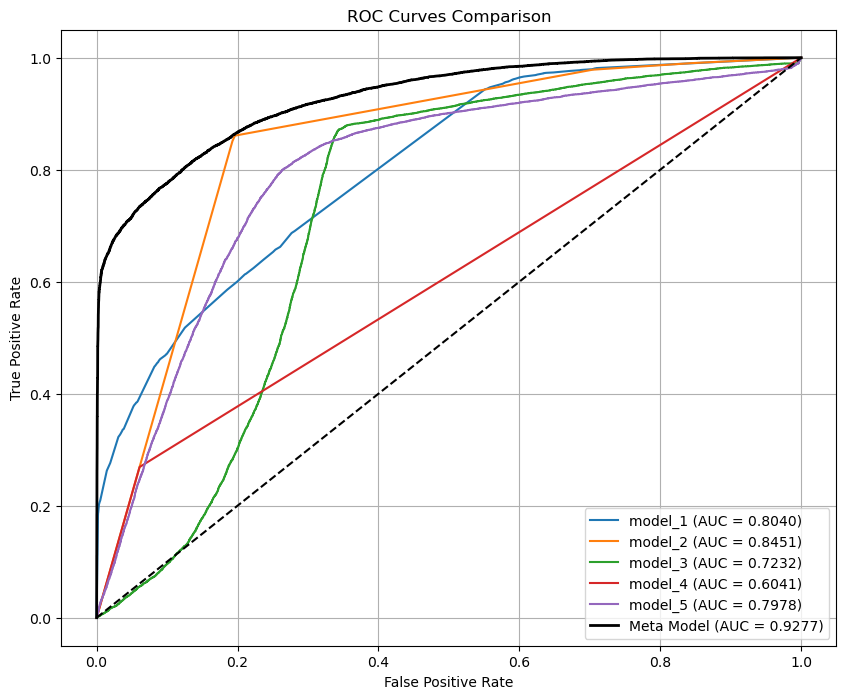

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve

plt.figure(figsize=(10, 8))

# 1. Кривые для отдельных моделей
for model_name in cols:
    fpr, tpr, _ = roc_curve(y_test, X_test[model_name])
    auc_score = roc_auc_score(y_test, X_test[model_name])
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})')

# 2. Кривая для мета-модели
fpr_meta, tpr_meta, _ = roc_curve(y_test, meta_predictions)
auc_meta = roc_auc_score(y_test, meta_predictions)
plt.plot(fpr_meta, tpr_meta, 'k-', linewidth=2, label=f'Meta Model (AUC = {auc_meta:.4f})')

# Линия случайной модели
plt.plot([0, 1], [0, 1], 'k--')

# Настройки графика
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [28]:
import numpy as np
import lightgbm as lgb
import optuna
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import pandas as pd

tr = pd.read_parquet('data/train.parquet')
tst = pd.read_parquet('data/test.parquet')

def train_meta_lgbm_with_optuna(train_predictions, y_train, test_predictions, n_trials=5):
    # Преобразуем DataFrame в numpy array для правильной работы с индексами
    X = train_predictions.values
    y = y_train.values
    
    # Оптимизация гиперпараметров LGBM
    def objective(trial):
        params = {
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
            'random_state': 42,
            'verbosity': -1
        }
        
        # Кросс-валидация
        scores = []
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        for train_idx, val_idx in skf.split(X, y):
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]
            
            model = lgb.LGBMClassifier(**params)
            model.fit(X_train_fold, y_train_fold,
                     eval_set=[(X_val_fold, y_val_fold)],
                     callbacks=[
                         lgb.early_stopping(stopping_rounds=50),
                         lgb.log_evaluation(50)
                     ])
            
            y_pred = model.predict_proba(X_val_fold)[:, 1]
            scores.append(roc_auc_score(y_val_fold, y_pred))
        
        return np.mean(scores)
    
    # Оптимизация
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    
    # Лучшие параметры
    best_params = study.best_params
    print(f"Best AUC: {study.best_value:.4f}")
    print("Best params:", best_params)
    
    # Финальная модель на всех данных
    final_model = lgb.LGBMClassifier(**best_params)
    final_model.fit(X, y)
    
    # Предсказание для теста
    test_meta_preds = final_model.predict_proba(test_predictions.values)[:, 1]
    
    return test_meta_preds

cols = ['model_1', 'model_2', 'model_3', 'model_4', 'model_5']

# Запуск модели
meta_predictions = train_meta_lgbm_with_optuna(
    tr.drop(columns=['target'])[cols], 
    tr.target, 
    tst[cols]
)

tst['pred'] = meta_predictions

[I 2025-05-18 10:38:01,841] A new study created in memory with name: no-name-5918732a-549b-47db-8940-395ac78c0d47


Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.925455
[100]	valid_0's auc: 0.925603
Early stopping, best iteration is:
[73]	valid_0's auc: 0.925664
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.92729
[100]	valid_0's auc: 0.92726


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[69]	valid_0's auc: 0.927366
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.927037
[100]	valid_0's auc: 0.927111


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[66]	valid_0's auc: 0.927148
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.925743
Early stopping, best iteration is:
[48]	valid_0's auc: 0.925766


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.927857
[100]	valid_0's auc: 0.928068


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-18 10:38:03,016] Trial 0 finished with value: 0.9268108776895909 and parameters: {'n_estimators': 273, 'learning_rate': 0.29128283238593505, 'num_leaves': 73, 'max_depth': 7, 'min_child_samples': 24, 'reg_alpha': 9.509154644382429, 'reg_lambda': 8.92292606488241}. Best is trial 0 with value: 0.9268108776895909.


[150]	valid_0's auc: 0.927988
Early stopping, best iteration is:
[108]	valid_0's auc: 0.92811
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.925007
[100]	valid_0's auc: 0.925629
[150]	valid_0's auc: 0.92573
[200]	valid_0's auc: 0.925726
Early stopping, best iteration is:
[184]	valid_0's auc: 0.925781


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.926847
[100]	valid_0's auc: 0.927388
Early stopping, best iteration is:
[99]	valid_0's auc: 0.927393


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.926517
[100]	valid_0's auc: 0.926933
[150]	valid_0's auc: 0.927173
[200]	valid_0's auc: 0.927216
Early stopping, best iteration is:
[175]	valid_0's auc: 0.927248
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.925276


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[100]	valid_0's auc: 0.925684
[150]	valid_0's auc: 0.925866
[200]	valid_0's auc: 0.925907
Early stopping, best iteration is:
[194]	valid_0's auc: 0.925916
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.927091
[100]	valid_0's auc: 0.927931


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-18 10:38:04,700] Trial 1 finished with value: 0.926868187222675 and parameters: {'n_estimators': 471, 'learning_rate': 0.16593571601994742, 'num_leaves': 24, 'max_depth': 9, 'min_child_samples': 81, 'reg_alpha': 9.548143052379075, 'reg_lambda': 5.9712655082442625}. Best is trial 1 with value: 0.926868187222675.


[150]	valid_0's auc: 0.928001
[200]	valid_0's auc: 0.927974
Early stopping, best iteration is:
[152]	valid_0's auc: 0.928003
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.923257
[100]	valid_0's auc: 0.924821
[150]	valid_0's auc: 0.925492
Did not meet early stopping. Best iteration is:
[165]	valid_0's auc: 0.925613
Training until validation scores don't improve for 50 rounds


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[50]	valid_0's auc: 0.924393
[100]	valid_0's auc: 0.926187
[150]	valid_0's auc: 0.926778
Did not meet early stopping. Best iteration is:
[165]	valid_0's auc: 0.926988
Training until validation scores don't improve for 50 rounds


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[50]	valid_0's auc: 0.924346
[100]	valid_0's auc: 0.925793
[150]	valid_0's auc: 0.92641
Did not meet early stopping. Best iteration is:
[165]	valid_0's auc: 0.926518
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.922254


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[100]	valid_0's auc: 0.924532
[150]	valid_0's auc: 0.92538
Did not meet early stopping. Best iteration is:
[165]	valid_0's auc: 0.925519


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.924029
[100]	valid_0's auc: 0.926071


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-18 10:38:06,868] Trial 2 finished with value: 0.9263526596739358 and parameters: {'n_estimators': 165, 'learning_rate': 0.02389971036026401, 'num_leaves': 227, 'max_depth': 11, 'min_child_samples': 82, 'reg_alpha': 5.853402081153024, 'reg_lambda': 8.313053639432104}. Best is trial 1 with value: 0.926868187222675.


[150]	valid_0's auc: 0.926931
Did not meet early stopping. Best iteration is:
[165]	valid_0's auc: 0.927124
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.924171
[100]	valid_0's auc: 0.925012
Did not meet early stopping. Best iteration is:
[146]	valid_0's auc: 0.925604
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.925854


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[100]	valid_0's auc: 0.926821
Did not meet early stopping. Best iteration is:
[147]	valid_0's auc: 0.927302
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.925325


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[100]	valid_0's auc: 0.926428
Did not meet early stopping. Best iteration is:
[146]	valid_0's auc: 0.92675
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.924313


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[100]	valid_0's auc: 0.925481
Did not meet early stopping. Best iteration is:
[147]	valid_0's auc: 0.925907
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.926094


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-18 10:38:08,080] Trial 3 finished with value: 0.9266678052453192 and parameters: {'n_estimators': 147, 'learning_rate': 0.0627273849575237, 'num_leaves': 27, 'max_depth': 7, 'min_child_samples': 42, 'reg_alpha': 3.1640704851166146, 'reg_lambda': 4.273195350753035}. Best is trial 1 with value: 0.926868187222675.


[100]	valid_0's auc: 0.927211
Did not meet early stopping. Best iteration is:
[145]	valid_0's auc: 0.927777
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.925285
[100]	valid_0's auc: 0.925805
[150]	valid_0's auc: 0.925848
Early stopping, best iteration is:
[110]	valid_0's auc: 0.925867
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.926507


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[100]	valid_0's auc: 0.927194
[150]	valid_0's auc: 0.927284
Early stopping, best iteration is:
[124]	valid_0's auc: 0.9273


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.92607
[100]	valid_0's auc: 0.92701
[150]	valid_0's auc: 0.927211
[200]	valid_0's auc: 0.927241
Did not meet early stopping. Best iteration is:
[216]	valid_0's auc: 0.927248


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.924945
[100]	valid_0's auc: 0.925702
[150]	valid_0's auc: 0.925731
[200]	valid_0's auc: 0.925788
Did not meet early stopping. Best iteration is:
[198]	valid_0's auc: 0.925794


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.926685
[100]	valid_0's auc: 0.927619


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-18 10:38:10,511] Trial 4 finished with value: 0.926868453373275 and parameters: {'n_estimators': 222, 'learning_rate': 0.06983840928077537, 'num_leaves': 99, 'max_depth': 12, 'min_child_samples': 36, 'reg_alpha': 9.975569834161163, 'reg_lambda': 2.518948603106994}. Best is trial 4 with value: 0.926868453373275.


[150]	valid_0's auc: 0.928004
[200]	valid_0's auc: 0.928111
Did not meet early stopping. Best iteration is:
[221]	valid_0's auc: 0.928134
Best AUC: 0.9269
Best params: {'n_estimators': 222, 'learning_rate': 0.06983840928077537, 'num_leaves': 99, 'max_depth': 12, 'min_child_samples': 36, 'reg_alpha': 9.975569834161163, 'reg_lambda': 2.518948603106994}


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [31]:
tst[['order_id', 'pred']].to_csv('lgb.csv', index=False)

In [32]:
tr

,target,order_create_time,session_end_time,model_1,model_2,model_3,model_4,model_5
0,1,1975-12-26 09:30:08,1975-12-26 09:21:03.393,0.798127,0.644805,0.039843,1,0.430339
1,0,1975-12-26 10:28:57,1975-12-26 11:01:03.407,-0.573826,0.220081,0.020889,0,0.177593
2,1,1975-12-25 11:24:28,1975-12-25 11:23:12.517,-0.665887,0.644805,0.039810,0,0.431897
3,1,1975-12-26 14:16:06,1975-12-26 14:29:57.153,-0.284625,0.644805,0.040026,0,0.432045
4,0,1975-12-26 18:21:47,1975-12-26 18:17:54.257,-1.710108,-0.221541,0.020585,0,0.174115
...,...,...,...,...,...,...,...,...
104590,1,1975-12-16 12:11:32,1975-12-16 12:56:06.990,-0.784541,0.220081,0.020901,0,0.188639
104591,1,1975-11-08 11:29:50,1975-11-07 23:55:00.773,-0.504846,0.220081,0.029831,0,0.175063
104592,0,1975-11-12 09:14:35,1975-11-12 09:15:26.047,-1.710108,-0.221541,0.021167,0,0.191408
104593,1,1975-11-10 17:28:07,1975-11-10 17:23:02.973,-0.403279,0.644805,0.040814,0,0.452594


In [33]:
tst

,order_id,order_create_time,session_end_time,model_1,model_2,model_3,model_4,model_5,pred
0,1350922,1976-02-05 15:08:37,1976-02-05 15:04:28.867,-1.710108,0.203183,0.040015,1,0.442343,0.022592
1,1354989,1976-02-07 15:26:00,1976-02-07 15:27:26.593,0.086020,0.220081,0.021101,1,0.191027,0.267034
2,1352637,1976-02-06 11:43:58,1976-02-05 18:34:59.477,-0.438741,0.644805,0.066312,0,0.400509,0.372329
3,1350050,1976-02-05 11:26:19,1976-02-05 11:09:28.247,-1.395752,0.203183,0.083039,1,0.414590,0.240389
4,1341733,1976-02-01 19:36:32,1976-02-01 09:53:54.103,-0.441443,0.644805,0.052902,0,0.411544,0.331215
...,...,...,...,...,...,...,...,...,...
17191,1358397,1976-02-09 16:13:20,1976-02-02 09:02:14.140,-0.429658,0.644805,0.908250,0,0.196781,0.241397
17192,1357968,1976-02-09 14:30:59,1976-02-09 14:26:24.480,-1.710108,0.203183,0.040665,0,0.411543,0.039310
17193,1358835,1976-02-09 18:39:45,1976-02-09 18:30:36.407,0.086020,0.644805,0.039744,1,0.426308,0.990211
17194,1365692,1976-02-12 17:50:18,1976-02-12 16:13:15.153,-1.710108,0.203183,0.041701,0,0.433750,0.061428
